# Trabalho Prático da disciplina de Análise de Dados Não Estruturados (2022/2023) - Segunda Parte

Instalation and imports

In [1]:
!pip install -q --upgrade keras-nlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 18.5 MB/s eta 0:00:00


In [2]:
import glob
import os
import itertools
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import keras_nlp
from keras_nlp.layers import PositionEmbedding, TransformerEncoder
from tensorflow import keras
from keras import models, layers
from keras.models import load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import SeparableConv1D, Conv1D, Dense, Flatten, LSTM, Input, Activation, BatchNormalization, TimeDistributed, Dropout, MaxPooling1D, Reshape
from datetime import datetime

Importing data

In [3]:
# Getting the training data (the join of four files: trainval1, trainval2, trainval3, trainval4)
def get_training_data():
  lista = []
  for x in range(1,5):
    x = str(x)
    dir = str('drive/MyDrive/trainval' + x + '/')
    train_list_wav_files = glob.glob(dir + '*.wav')
    lista.append(train_list_wav_files)
  return list(itertools.chain.from_iterable(lista))

validation = os.path.join('drive', 'MyDrive/trainval5', '*.wav')
testing = os.path.join('drive', 'MyDrive/test', '*.wav')
validation_files = glob.glob(validation)
test_files= glob.glob(testing)

train_dataset = tf.data.Dataset.from_tensor_slices(get_training_data())
val_dataset = tf.data.Dataset.from_tensor_slices(validation_files)
test_dataset = tf.data.Dataset.from_tensor_slices(test_files)

Loading WAV files and padding

In [4]:
@tf.function
def load_wav_8k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 8 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    # Faz o load da versão encoded do ficheiro wav e produz uma byte encoded string (versão decoded do wav file)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Faz o decode da wav e é especificado que só queremos um channel (em vez de stereo audio, temos mono audio)
    # o que torna o processamento do som mais fácil mais à frente
    # Produz o wav, cuja shape diz respeito à representação da waveform (amplitude de onda??) (pode ser visualizado num gráfico)
    # sample_rate diz respeito aos ciclos por segundo. Sample_rate dividido pelo valor da contido na shape da wav dá-nos os segundos (duração do som).
    wav = tf.squeeze(wav, axis=-1)
    # O squeeze faz desaparecer o valor 1 presente no shape
    wav = tf.math.l2_normalize(wav, axis=0)
    # Faz a normalização L2 dos dados no eixo indicado
    l = tf.shape(wav)[0]
    if  l < 32000:
        wav = tf.pad(wav, [[0, 32000 - l]])
    # É feito o padding de zeros para todos os valores de wav que sejam inferiores a 32000, que neste caso corresponde ao máximo valor.
    return wav

In [5]:
lengths = []
for file in val_dataset:
    tensor_wave = load_wav_8k_mono(file)
    lengths.append(len(tensor_wave))

lengths

print(tf.math.reduce_mean(lengths))
print(tf.math.reduce_min(lengths))
print(tf.math.reduce_max(lengths))

tf.Tensor(32000, shape=(), dtype=int32)
tf.Tensor(32000, shape=(), dtype=int32)
tf.Tensor(32000, shape=(), dtype=int32)


In [6]:
file_contents1 = tf.io.read_file('drive/MyDrive/trainval1/100648-1-0-0.wav') # Shape = (5189,1)

In [7]:
file_contents1 = tf.io.read_file('drive/MyDrive/trainval1/100263-2-0-137.wav') # Shape = (32000,1)

In [8]:
wav1, sample_rate1 = tf.audio.decode_wav(file_contents1, desired_channels=1)

In [9]:
print(sample_rate1)

tf.Tensor(8000, shape=(), dtype=int32)


In [10]:
print(wav1)

tf.Tensor(
[[0.00219727]
 [0.00534058]
 [0.0020752 ]
 ...
 [0.00524902]
 [0.0012207 ]
 [0.0022583 ]], shape=(32000, 1), dtype=float32)


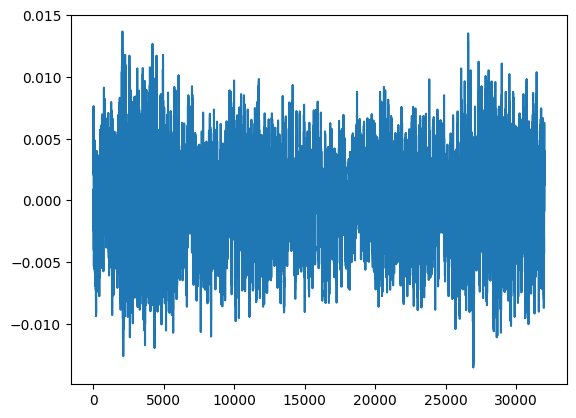

In [11]:
plt.plot(wav1)
plt.show()

In [12]:
def get_label(wavFname):
    baseName = tf.strings.split(wavFname, sep='/')[-1]
    classLabel = tf.strings.split(baseName, sep='-')[1]
    return int(classLabel)

In [13]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(waveform, frame_length=250, frame_step=126)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  #spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [14]:
dt1 = train_dataset.map(lambda x: load_wav_8k_mono(x))
dt2 = train_dataset.map(lambda x: (load_wav_8k_mono(x), get_label(x)))
dt3 = dt2.map(lambda x,y: (get_spectrogram(x),y))
dt4_f = dt3.padded_batch(batch_size=64, padded_shapes=([None,129],[]))

dv1 = val_dataset.map(lambda x: load_wav_8k_mono(x))
dv2 = val_dataset.map(lambda x: (load_wav_8k_mono(x), get_label(x)))
dv3 = dv2.map(lambda x,y: (get_spectrogram(x),y))
dv4_f = dv3.padded_batch(batch_size=2, padded_shapes=([None,129],[]))

dtt1 = test_dataset.map(lambda x: load_wav_8k_mono(x))
dtt2 = test_dataset.map(lambda x: (load_wav_8k_mono(x), get_label(x)))
dtt3 = dtt2.map(lambda x,y: (get_spectrogram(x),y))
dtt4_f = dtt3.padded_batch(batch_size=1, padded_shapes=([None,129],[]))

In [15]:
it = iter(dt3)

In [16]:
ex = next(it)
ex

(<tf.Tensor: shape=(252, 129), dtype=float32, numpy=
 array([[7.17913955e-02, 7.90762380e-02, 3.80871370e-02, ...,
         2.07023204e-05, 7.03405158e-06, 8.94069672e-06],
        [6.04527891e-02, 8.01034048e-02, 3.34363431e-02, ...,
         2.23355801e-05, 1.54779573e-05, 9.23871994e-06],
        [5.34408875e-02, 6.23851158e-02, 1.19619459e-01, ...,
         1.19380675e-05, 1.23659593e-05, 9.14558768e-06],
        ...,
        [1.64589494e-01, 1.36426881e-01, 1.24488920e-01, ...,
         9.93508220e-05, 1.05248255e-05, 6.47455454e-06],
        [1.32053375e-01, 1.68034256e-01, 5.87514155e-02, ...,
         5.18480119e-05, 2.47994967e-06, 6.94394112e-06],
        [1.44442111e-01, 4.81120721e-02, 9.84517634e-02, ...,
         4.10967987e-05, 2.84734051e-05, 1.31726265e-05]], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=int32, numpy=0>)

<function matplotlib.pyplot.show(close=None, block=None)>

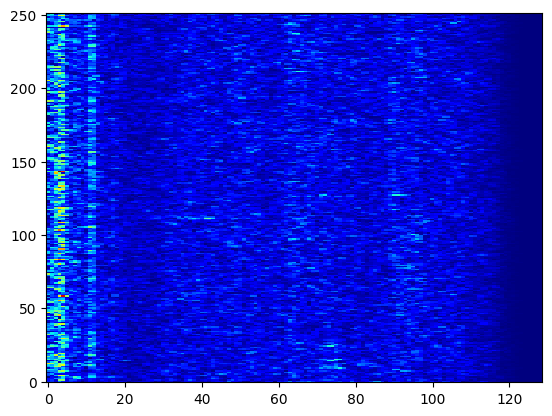

In [17]:
plt.imshow(ex[0],origin='lower', cmap='jet', interpolation='nearest', aspect='auto')
plt.show

Modelo CNN

In [18]:
##### Modelo CNN #####
def model_cnn():
  model_c = Sequential()
  model_c.add(tf.keras.layers.SeparableConv1D(64, 3, padding="same", strides=2, activation='relu', input_shape=(None, 129)))
  model_c.add(tf.keras.layers.BatchNormalization())
  model_c.add(tf.keras.layers.MaxPooling1D())
  model_c.add(tf.keras.layers.SpatialDropout1D(0.25))
  ##
  model_c.add(tf.keras.layers.SeparableConv1D(128, 3, padding="same", strides=2, activation='relu'))
  model_c.add(tf.keras.layers.BatchNormalization())
  model_c.add(tf.keras.layers.MaxPooling1D())
  model_c.add(tf.keras.layers.SpatialDropout1D(0.25))
  ##
  model_c.add(tf.keras.layers.SeparableConv1D(256, 3, padding="same", strides=2, activation='relu'))
  model_c.add(tf.keras.layers.BatchNormalization())
  model_c.add(tf.keras.layers.GlobalMaxPooling1D())
  #model_c.add(tf.keras.layers.SpatialDropout1D(0.25))
  ##
  #model_c.add(tf.keras.layers.Flatten())
  model_c.add(tf.keras.layers.Dense(512, activation='relu'))
  model_c.add(tf.keras.layers.Dropout(0.25))
  model_c.add(tf.keras.layers.Dense(10, activation='softmax'))
  return model_c

# Guardar pesos
fp1="cnn_best_weights.h5"
checkpoint = ModelCheckpoint(fp1, monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=True,  mode='max')
callbacks_list = [checkpoint]

# Correr o modelo
model_cnn1=model_cnn()
model_cnn1.summary()
model_cnn1.compile(optimizer=Adam(learning_rate=1e-4), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=tf.keras.metrics.SparseCategoricalAccuracy())
history_cnn=model_cnn1.fit(dt4_f, validation_data=dv4_f, epochs=200, callbacks=callbacks_list)
model_cnn1.save_weights('cnn_weights.h5', overwrite=True, save_format=None, options=None)
model_cnn1.save('cnn_final.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 separable_conv1d (Separable  (None, None, 64)         8707      
 Conv1D)                                                         
                                                                 
 batch_normalization (BatchN  (None, None, 64)         256       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 64)         0         
 )                                                               
                                                                 
 spatial_dropout1d (SpatialD  (None, None, 64)         0         
 ropout1D)                                                       
                                                                 
 separable_conv1d_1 (Separab  (None, None, 128)        8

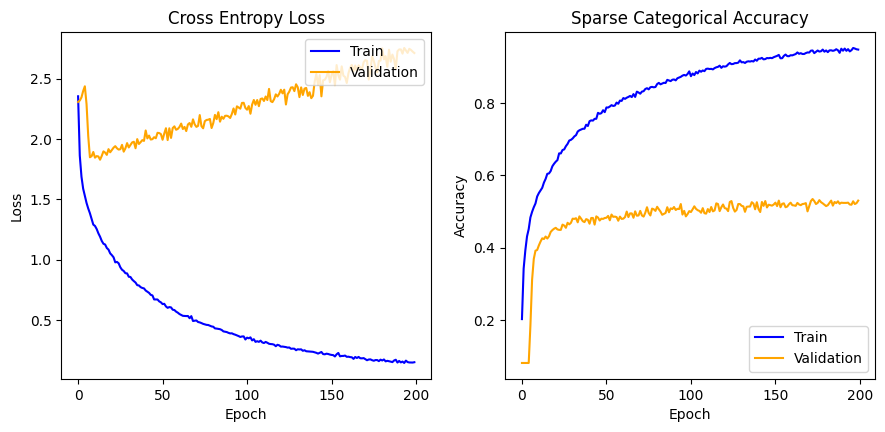

In [20]:
def plots(history, epochs=200):
    a_epochs=np.arange(epochs)
    # Plot Loss
    plt.figure(figsize=(10.5,4.5))
    plt.subplot(1, 2, 1)
    plt.title('Cross Entropy Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(a_epochs,history_cnn.history['loss'], color='blue', label='Train')
    plt.plot(a_epochs,history_cnn.history['val_loss'], color='orange', label='Validation')
    plt.legend(loc="upper right")
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.title('Sparse Categorical Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(a_epochs,history_cnn.history['sparse_categorical_accuracy'], color='blue', label='Train')
    plt.plot(a_epochs,history_cnn.history['val_sparse_categorical_accuracy'], color='orange', label='Validation')
    plt.legend(loc="lower right")
    plt.show()

plots(history_cnn, 200)

In [22]:
##### FASE DE TESTE #####
model_cnn_run = load_model('cnn_final.h5')
print('Teste para o Modelo CNN:')
loss_metrics = model_cnn_run.evaluate(dtt4_f, verbose=2)
print('Loss:', loss_metrics[0], 'Accuracy:',loss_metrics[1])

Teste para o Modelo CNN:
436/436 - 2s - loss: 1.8706 - sparse_categorical_accuracy: 0.6399 - 2s/epoch - 5ms/step
Loss: 1.8706135749816895 Accuracy: 0.6399082541465759


Modelo RNN

In [ ]:
def model_rnn():
 model_r = Sequential()
 model_r.add(tf.keras.layers.SeparableConv1D(64, 3, padding="same", strides=2, activation='relu', input_shape=(None, 129)))
 model_r.add(tf.keras.layers.BatchNormalization())
 model_r.add(tf.keras.layers.MaxPooling1D())
 model_r.add(tf.keras.layers.Dropout(0.25))
 ##
 model_r.add(tf.keras.layers.SeparableConv1D(128, 3, padding="same", strides=2, activation='relu'))
 model_r.add(tf.keras.layers.BatchNormalization())
 model_r.add(tf.keras.layers.MaxPooling1D())
 model_r.add(tf.keras.layers.Dropout(0.25))
 ##
 model_r.add(tf.keras.layers.LSTM(90, return_sequences=True, kernel_initializer="he_uniform", dropout=0.25))
 model_r.add(tf.keras.layers.LSTM(90, return_sequences=False, kernel_initializer="he_uniform", dropout=0.25))
 ##
 model_r.add(tf.keras.layers.Dense(512, activation='relu'))
 model_r.add(tf.keras.layers.Dropout(0.25))
 model_r.add(tf.keras.layers.Dense(10, activation='softmax'))
 return model_r

# Guardar pesos
fp2="rnn_best_weights.h5"
checkpoint2 = ModelCheckpoint(fp2, monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=True,  mode='max')
callbacks_list2 = [checkpoint2]

# Correr o modelo
model_rnn1=model_rnn()
model_rnn1.summary()
model_rnn1.compile(optimizer=Adam(learning_rate=1e-4), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=tf.keras.metrics.SparseCategoricalAccuracy())
history_rnn=model_rnn1.fit(dt4_f, validation_data=dv4_f, epochs=200, callbacks=callbacks_list2)
model_rnn1.save_weights('rnn_weights.h5', overwrite=True, save_format=None, options=None)
model_rnn1.save('rnn_final.h5')

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 separable_conv1d_21 (Separa  (None, None, 64)         8707      
 bleConv1D)                                                      
                                                                 
 batch_normalization_54 (Bat  (None, None, 64)         256       
 chNormalization)                                                
                                                                 
 max_pooling1d_21 (MaxPoolin  (None, None, 64)         0         
 g1D)                                                            
                                                                 
 dropout_34 (Dropout)        (None, None, 64)          0         
                                                                 
 separable_conv1d_22 (Separa  (None, None, 128)        8512      
 bleConv1D)                                          

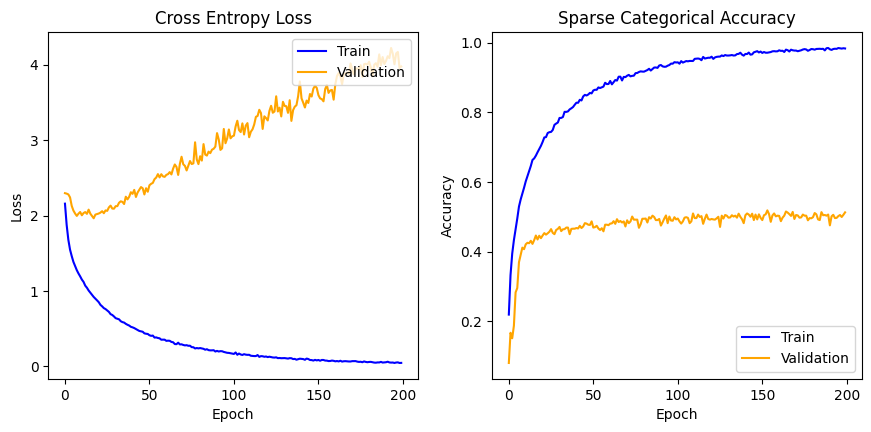

In [ ]:
def plots(history, epochs=200):
    a_epochs=np.arange(epochs)
    # Plot Loss
    plt.figure(figsize=(10.5,4.5))
    plt.subplot(1, 2, 1)
    plt.title('Cross Entropy Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(a_epochs,history_rnn.history['loss'], color='blue', label='Train')
    plt.plot(a_epochs,history_rnn.history['val_loss'], color='orange', label='Validation')
    plt.legend(loc="upper right")
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.title('Sparse Categorical Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(a_epochs,history_rnn.history['sparse_categorical_accuracy'], color='blue', label='Train')
    plt.plot(a_epochs,history_rnn.history['val_sparse_categorical_accuracy'], color='orange', label='Validation')
    plt.legend(loc="lower right")
    plt.show()

plots(history_rnn, 200)

In [ ]:
##### FASE DE TESTE #####
model_rnn_run = load_model('rnn_final.h5')
print('Teste para o Modelo RNN:')
loss_metrics2 = model_rnn_run.evaluate(dtt4_f, verbose=2)
print('Loss:', loss_metrics2[0], 'Accuracy:',loss_metrics2[1])

Teste para o Modelo RNN:
436/436 - 2s - loss: 2.3688 - sparse_categorical_accuracy: 0.6376 - 2s/epoch - 5ms/step
Loss: 2.368825912475586 Accuracy: 0.6376146674156189


Modelo Transformer

In [30]:
def model_transformer():
  inputs = tf.keras.Input(shape=(None, 129))
  ##
  x = tf.keras.layers.Conv1D(64, 3, padding="same", strides=2, activation='relu')(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.MaxPooling1D()(x)
  x = tf.keras.layers.Dropout(0.25)(x)
  ##
  x = tf.keras.layers.Conv1D(128, 3, padding="same", strides=2, activation='relu')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.MaxPooling1D()(x)
  x = tf.keras.layers.Dropout(0.25)(x)
  ##
  x = keras_nlp.layers.PositionEmbedding(sequence_length = 256)(x)
  x = keras_nlp.layers.TransformerEncoder(intermediate_dim=129, num_heads=10)(x)
  ##
  x = tf.keras.layers.Dense(512, activation='relu')(x[:,0])
  x = tf.keras.layers.Dropout(0.25)(x)
  outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
  ##
  model_t = tf.keras.Model(inputs=inputs, outputs=outputs)
  return model_t

# Guardar pesos
fp3="tra_best_weights.h5"
checkpoint3 = ModelCheckpoint(fp3, monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=True,  mode='max')
callbacks_list3 = [checkpoint3]

# Correr o modelo
model_tra1=model_transformer()
model_tra1.summary()
model_tra1.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=tf.keras.metrics.SparseCategoricalAccuracy())
history_tra=model_tra1.fit(dt4_f, validation_data=dv4_f, epochs=20, callbacks=callbacks_list3)
model_tra1.save_weights('tra_weights.h5', overwrite=True, save_format=None, options=None)
model_tra1.save('tra_final.h5')

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None, 129)]       0         
                                                                 
 conv1d_14 (Conv1D)          (None, None, 64)          24832     
                                                                 
 batch_normalization_17 (Bat  (None, None, 64)         256       
 chNormalization)                                                
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, None, 64)         0         
 g1D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, None, 64)          0         
                                                                 
 conv1d_15 (Conv1D)          (None, None, 128)         2470

99/99 [==============================] - ETA: 0s - loss: 2.3385 - sparse_categorical_accuracy: 0.1434
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.09488, saving model to tra_best_weights.h5
99/99 [==============================] - 34s 303ms/step - loss: 2.3385 - sparse_categorical_accuracy: 0.1434 - val_loss: 2.4415 - val_sparse_categorical_accuracy: 0.0949
Epoch 2/20
99/99 [==============================] - ETA: 0s - loss: 2.2931 - sparse_categorical_accuracy: 0.1524
Epoch 2: val_sparse_categorical_accuracy improved from 0.09488 to 0.12524, saving model to tra_best_weights.h5
99/99 [==============================] - 30s 303ms/step - loss: 2.2931 - sparse_categorical_accuracy: 0.1524 - val_loss: 2.3157 - val_sparse_categorical_accuracy: 0.1252
Epoch 3/20
99/99 [==============================] - ETA: 0s - loss: 2.2612 - sparse_categorical_accuracy: 0.1464
Epoch 3: val_sparse_categorical_accuracy did not improve from 0.12524
99/99 [==============================] - 30